## Reciprocal Dyad Analysis
This notebook includes analysis of **reciprocal balance, site-creation dependent reciprocation, and (soon) cycle analysis**

In [1]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
import pylab as pl
from tqdm import tqdm
from collections import defaultdict

m_to_d = (1000 * 60 * 60 * 24)
m_to_hr = (1000 * 60 * 60)
#right bound for balance vis
rb = 2
ts_2014 = 1388556000000

metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
h5_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/dyad_growth/h5"

In [2]:
dyads = pd.read_hdf(os.path.join(h5_dir, "recips_nonreduced_inttype.h5")) #change to new reciprocal set

In [3]:
dyads = dyads.sort_values(by="created_at")
dyads

,from_user_id,to_user_id,created_at,int_type
3945,386,28,1117710956000,guestbook
5450,597,486,1117747707000,guestbook
5468,600,28,1117748166000,guestbook
3556,248,33,1117754812000,guestbook
3482,167,685473,1117776105000,guestbook
...,...,...,...,...
3114587,29672305,29542085,1549791032000,amps
3109837,29560275,30632091,1549803934000,amps
3169581,33321624,32819111,1549806269000,amps
2532659,13413312,18738494,1549811660000,amps


In [4]:
dyads.int_type.unique()

array(['guestbook', 'amps', 'comment'], dtype=object)

In [5]:
ind_from = {from_user: to_user for from_user, to_user in zip(dyads.index, dyads["from_user_id"])}
ind_at = {from_user: to_user for from_user, to_user in zip(dyads.index, dyads["created_at"])}
ind_to = {from_user: to_user for from_user, to_user in zip(dyads.index, dyads["to_user_id"])}
ind_int = {from_user: to_user for from_user, to_user in zip(dyads.index, dyads["int_type"])}

### Balance between Initiator-Recipient

In [6]:
ratios = {}
for ind in tqdm(dyads.index):
    from_uid = ind_from[ind]
    created_at = ind_at[ind]
    to_uid = ind_to[ind]
    if created_at > ts_2014:
        if (from_uid, to_uid) in ratios.keys():
            ratios[(from_uid, to_uid)] = (ratios[(from_uid, to_uid)][0] + 1, ratios[(from_uid, to_uid)][1])
        elif (to_uid, from_uid) in ratios.keys():
            ratios[(to_uid, from_uid)] =  (ratios[(to_uid, from_uid)][0], ratios[(to_uid, from_uid)][1] + 1)
        else:
            ratios[(from_uid, to_uid)] = (1, 0)

100%|██████████| 3169946/3169946 [00:04<00:00, 750169.69it/s]


In [7]:
int_ratios = {}
for ind in tqdm(dyads.index):
    from_uid = ind_from[ind]
    created_at = ind_at[ind]
    to_uid = ind_to[ind]
    int_type = ind_int[ind]
    if created_at > ts_2014:
        if (from_uid, to_uid, int_type) in int_ratios.keys():
            int_ratios[(from_uid, to_uid, int_type)] = (int_ratios[(from_uid, to_uid, int_type)][0] + 1, int_ratios[(from_uid, to_uid, int_type)][1])
        elif (to_uid, from_uid, int_type) in int_ratios.keys():
            int_ratios[(to_uid, from_uid, int_type)] =  (int_ratios[(to_uid, from_uid, int_type)][0], int_ratios[(to_uid, from_uid, int_type)][1] + 1)
        else:
            int_ratios[(from_uid, to_uid, int_type)] = (1, 0)

100%|██████████| 3169946/3169946 [00:05<00:00, 602818.17it/s]


In [8]:
overall_balance = [x[0] / x[1] if x[1] != 0 else x[0] for x in ratios.values()]
shared_control = [x for x in overall_balance if x == 1]
init_control = [x for x in overall_balance if x > 1]
recv_control = [x for x in overall_balance if x < 1]
print("Ratio =1: {}\t\tRatio >1 (Init): {}\t Ratio <1 (Recv): {}\t".format(len(shared_control), len(init_control), len(recv_control)))
print("Ratio =1: {}%\t\tRatio >1 (Init): {}%\t Ratio <1 (Recv): {}%\t".format(100 *len(shared_control)/len(overall_balance), 100 * len(init_control)/len(overall_balance), 100 * len(recv_control)/len(overall_balance)))

Ratio =1: 8832		Ratio >1 (Init): 28070	 Ratio <1 (Recv): 7336	
Ratio =1: 19.964736199647362%		Ratio >1 (Init): 63.45223563452235%	 Ratio <1 (Recv): 16.58302816583028%	


In [9]:
pcts = np.array([(x[0] / (x[1] + x[0]), x[0], x[1], x[0]+x[1]) for x in ratios.values() if x[1] != 0])

#### Overall
The ratio is _initiator/receiver_, which is intriguing, since this suggests that it is more common for the receiver to interact in a reciprocal and cyclic relationship.

(0.0, 500)

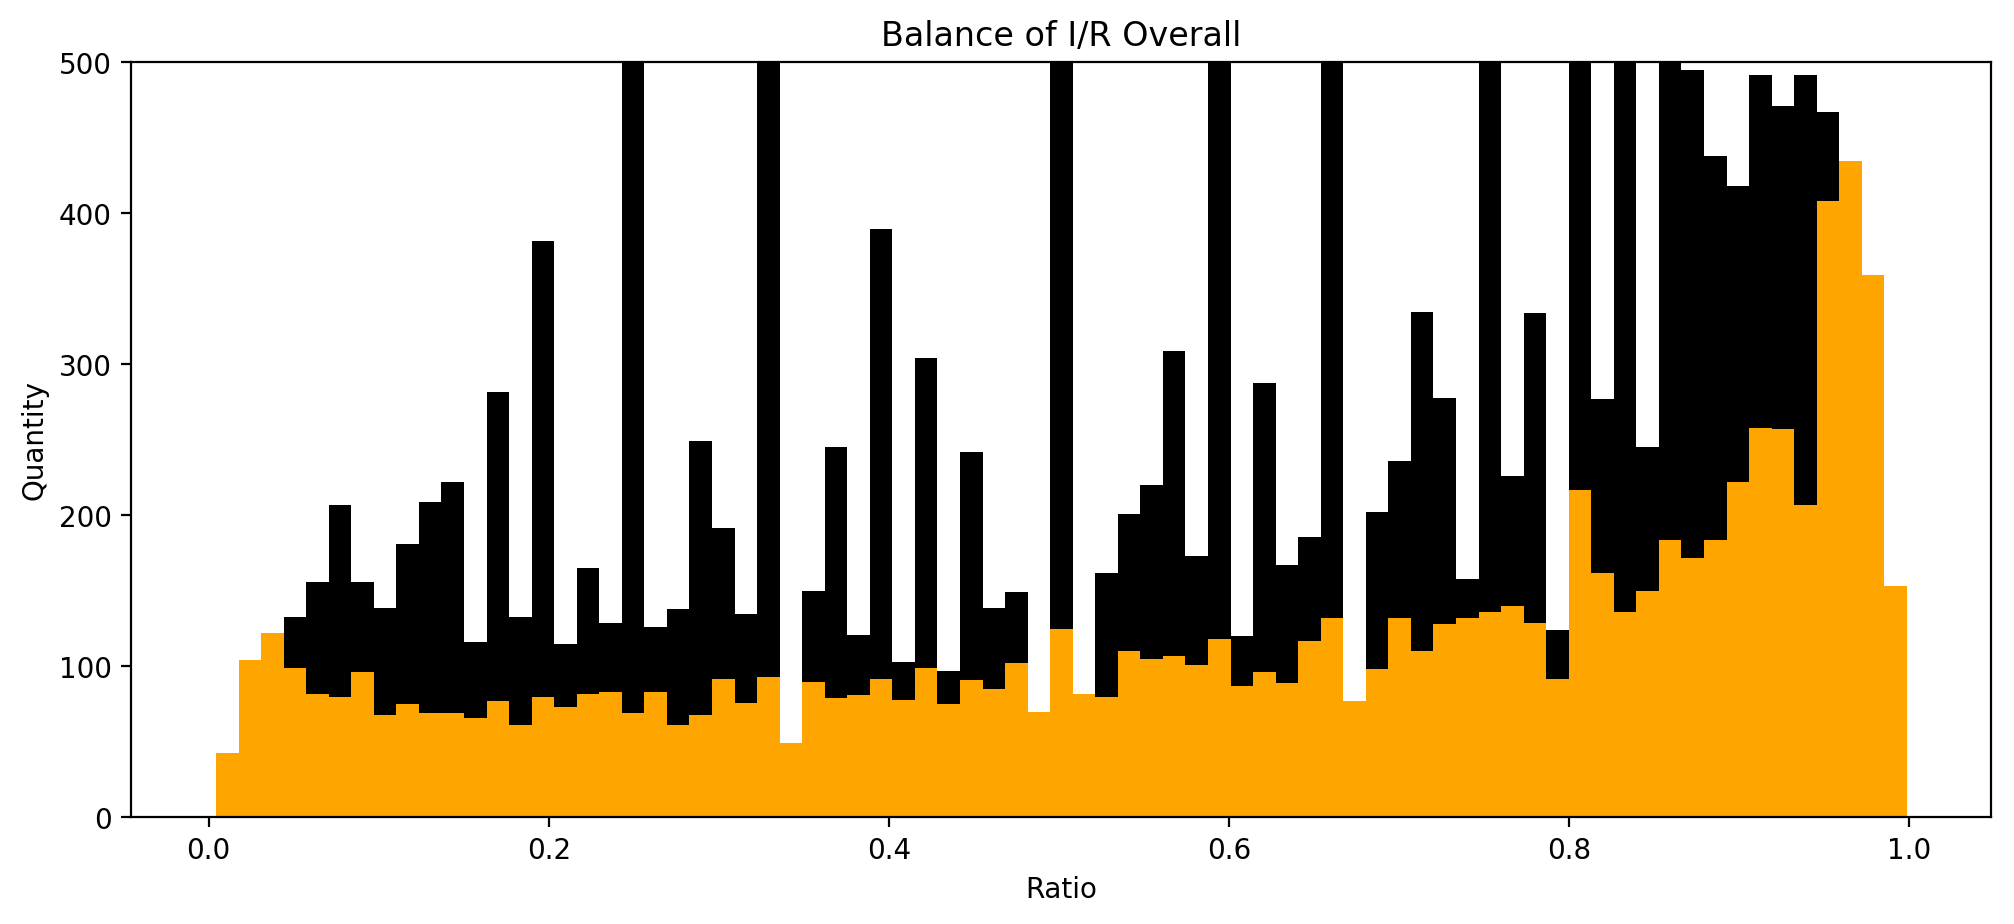

In [10]:
#trimmed_balance = [x for x in overall_balance if x > 0 and x < 2]
fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi= 200, facecolor='w', edgecolor='k')
hist, bins, _ = ax.hist(pcts[:,0], bins=75, color='black')
hist, bins, _ = ax.hist(pcts[pcts[:,3] >= 20,0], bins=75, color='orange')
ax.set_xlabel("Percentage")
ax.set_ylabel("Quantity")
ax.set_title("Balance of I/R Overall")
ax.set_xlabel("Ratio")
ax.set_ylabel("Quantity")
ax.set_ylim(top=500)
#check on num ints, > 10 or 20

In [11]:
np.mean(pcts[pcts[:,3] >= 20,0]), np.std(pcts[pcts[:,3] >= 20,0])

(0.6222972918672837, 0.2981601015887738)

#### Cofounded by Interaction Type
In all three interaction types, the receiver is more likely to overpower the balance. However, guestbooks very prominently show this effect.

In [12]:
gbks = np.array([(x[0] / (x[1] + x[0]), x[0], x[1], x[0]+x[1]) for y, x in zip(int_ratios.keys(), int_ratios.values()) if y[2] == "guestbook"])
amps = np.array([(x[0] / (x[1] + x[0]), x[0], x[1], x[0]+x[1]) for y, x in zip(int_ratios.keys(), int_ratios.values()) if y[2] == "amps"])
coms = np.array([(x[0] / (x[1] + x[0]), x[0], x[1], x[0]+x[1]) for y, x in zip(int_ratios.keys(), int_ratios.values()) if y[2] == "comment"])

(0.0, 2000)

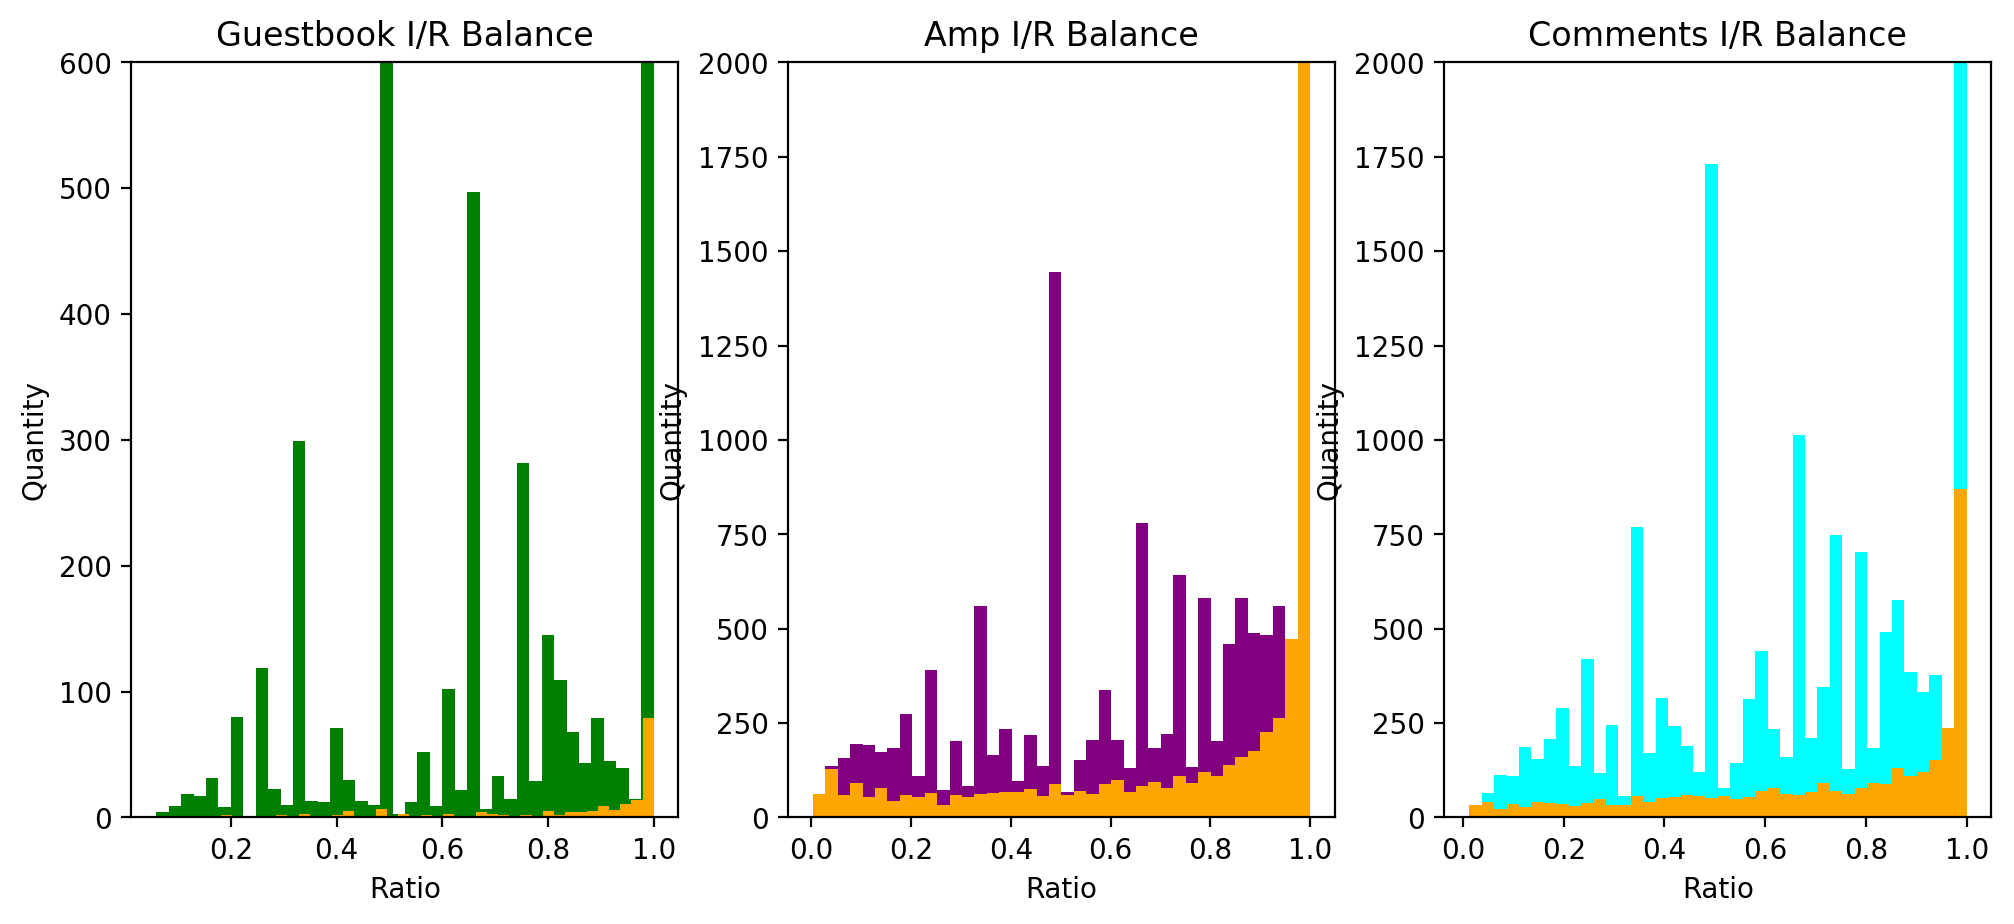

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5), dpi= 200, facecolor='w', edgecolor='k')
hist, bins, _ = ax[0].hist([x for x in gbks[:,0]], bins=40, color='green')
hist, bins, _ = ax[0].hist(gbks[gbks[:,3] >= 20,0], bins=40, color='orange')
ax[0].set_ylabel("Quantity")
ax[0].set_xlabel("Ratio")
ax[0].set_title("Guestbook I/R Balance")
ax[0].set_ylim(top=600)

hist, bins, _ = ax[1].hist([x for x in amps[:,0]], bins=40, color='purple')
hist, bins, _ = ax[1].hist(amps[amps[:,3] >= 20,0], bins=40, color='orange')
ax[1].set_ylabel("Quantity")
ax[1].set_xlabel("Ratio")
ax[1].set_title("Amp I/R Balance")
ax[1].set_ylim(top=2000)

hist, bins, _ = ax[2].hist([x for x in coms[:,0]], bins=40, color='cyan')
hist, bins, _ = ax[2].hist(coms[coms[:,3] >= 20,0], bins=40, color='orange')
ax[2].set_ylabel("Quantity")
ax[2].set_xlabel("Ratio")
ax[2].set_title("Comments I/R Balance")
ax[2].set_ylim(top=2000)

In [ ]:
gbks_shared_control = [x for x in gbks if x == 1]
gbks_init_control = [x for x in gbks if x > 1]
gbks_recv_control = [x for x in gbks if x < 1]
print("GUESTBOOKS")
print("Ratio =1: {}\t\tRatio >1 (Init): {}\t Ratio <1 (Recv): {}\t".format(len(gbks_shared_control), len(gbks_init_control), len(gbks_recv_control)))
print("Ratio =1: {}%\t\tRatio >1 (Init): {}%\t Ratio <1 (Recv): {}%\t".format(100 *len(gbks_shared_control)/len(gbks), 100 * len(gbks_init_control)/len(gbks), 100 * len(gbks_recv_control)/len(gbks)))

In [ ]:
gbks_shared_control = [x for x in amps if x == 1]
gbks_init_control = [x for x in amps if x > 1]
gbks_recv_control = [x for x in amps if x < 1]
print("AMPS")
print("Ratio =1: {}\t\tRatio >1 (Init): {}\t Ratio <1 (Recv): {}\t".format(len(gbks_shared_control), len(gbks_init_control), len(gbks_recv_control)))
print("Ratio =1: {}%\t\tRatio >1 (Init): {}%\t Ratio <1 (Recv): {}%\t".format(100 *len(gbks_shared_control)/len(amps), 100 * len(gbks_init_control)/len(amps), 100 * len(gbks_recv_control)/len(amps)))

In [ ]:
gbks_shared_control = [x for x in coms if x == 1]
gbks_init_control = [x for x in coms if x > 1]
gbks_recv_control = [x for x in coms if x < 1]
print("COMMENTS")
print("Ratio =1: {}\t\tRatio >1 (Init): {}\t Ratio <1 (Recv): {}\t".format(len(gbks_shared_control), len(gbks_init_control), len(gbks_recv_control)))
print("Ratio =1: {}%\t\tRatio >1 (Init): {}%\t Ratio <1 (Recv): {}%\t".format(100 *len(gbks_shared_control)/len(coms), 100 * len(gbks_init_control)/len(coms), 100 * len(gbks_recv_control)/len(coms)))

Text(0.5, 1.0, 'Heat Map of Balances')

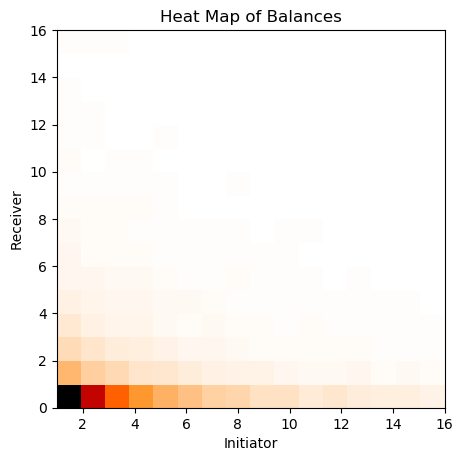

In [18]:
from scipy.stats import kde
bound = 17
cratios = [x for x in ratios.values() if x[0] < bound and x[1] < bound]

x = np.array([x[0] for x in cratios])
y = np.array([x[1] for x in cratios])
 
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi= 100, facecolor='w', edgecolor='k')
ax.hist2d(x, y, bins=bound -1, cmap=plt.cm.gist_heat_r)
ax.set_ylabel("Receiver")
ax.set_xlabel("Initiator")
ax.set_title("Heat Map of Balances")

### Site-Creation Dependence
In order for reciprocation to happen, both users must have a site. Almost 50% of the time, the initiator doesn't have a site before initiating... does this make a difference in distribution?

In [8]:
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
df = pd.read_hdf(author_to_site)
sorted_df = df.sort_values(by=["user_id", "site_id"])
journals = sorted_df[sorted_df.int_type == "journal"]

In [9]:
firsts = journals.sort_values(by=["user_id", "created_at"]).drop_duplicates(subset=['user_id'], keep='first')
firsts.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
22617659,0,654403,journal,0,1369095675000,51be89ac6ca004ea300028f5,0.0,True,True
10495558,1,1,journal,1103856900000,1103856900000,51bdf3e56ca0048f4e00ced4,0.0,True,True
10495745,2,2,journal,1117053060000,1117053060000,51bdf3e56ca0048f4e00cefa,0.0,True,True
10495774,3,3,journal,1117605718000,1117605718000,51bdf3e56ca0048f4e00ccd6,0.0,False,True
10495775,4,4,journal,1117605820000,1117605820000,51bdf3e56ca0048f4e00ccd8,0.0,False,True


In [10]:
first_site = {from_uid : created_at for from_uid, created_at in zip(firsts.user_id, firsts.created_at)}

In [11]:
sited = []

unsited = []
for ind in tqdm(dyads.index):
    from_uid = ind_from[ind]
    created_at = ind_at[ind]
    to_uid = ind_to[ind]
    int_type = ind_int[ind]
    if created_at < first_site[from_uid]:
        unsited.append((from_uid, to_uid, created_at, int_type))
    else:
        sited.append((from_uid, to_uid, created_at, int_type))

100%|██████████| 3169946/3169946 [00:07<00:00, 415729.78it/s]


In [12]:
len(sited) / 3169946 # 89% of interactions are sited

0.890941359884364

In [13]:
len(unsited) / 3169946 # 11% of interactions are unsited

0.10905864011563604

In [14]:
s = pd.DataFrame(sited, columns=["from_user_id", "to_user_id", "created_at", "int_type"])
us = pd.DataFrame(unsited, columns=["from_user_id", "to_user_id", "created_at", "int_type"])
s.to_hdf(os.path.join(h5_dir, "recips_sited.h5"), key="s")
us.to_hdf(os.path.join(h5_dir, "recips_unsited.h5"), key="us")

In [15]:
red = pd.read_hdf(os.path.join(h5_dir, "recips_reduced.h5"))
unsited = red[red["from"].isin(us["from_user_id"])]
sited = red[red["from"].isin(s["from_user_id"])]

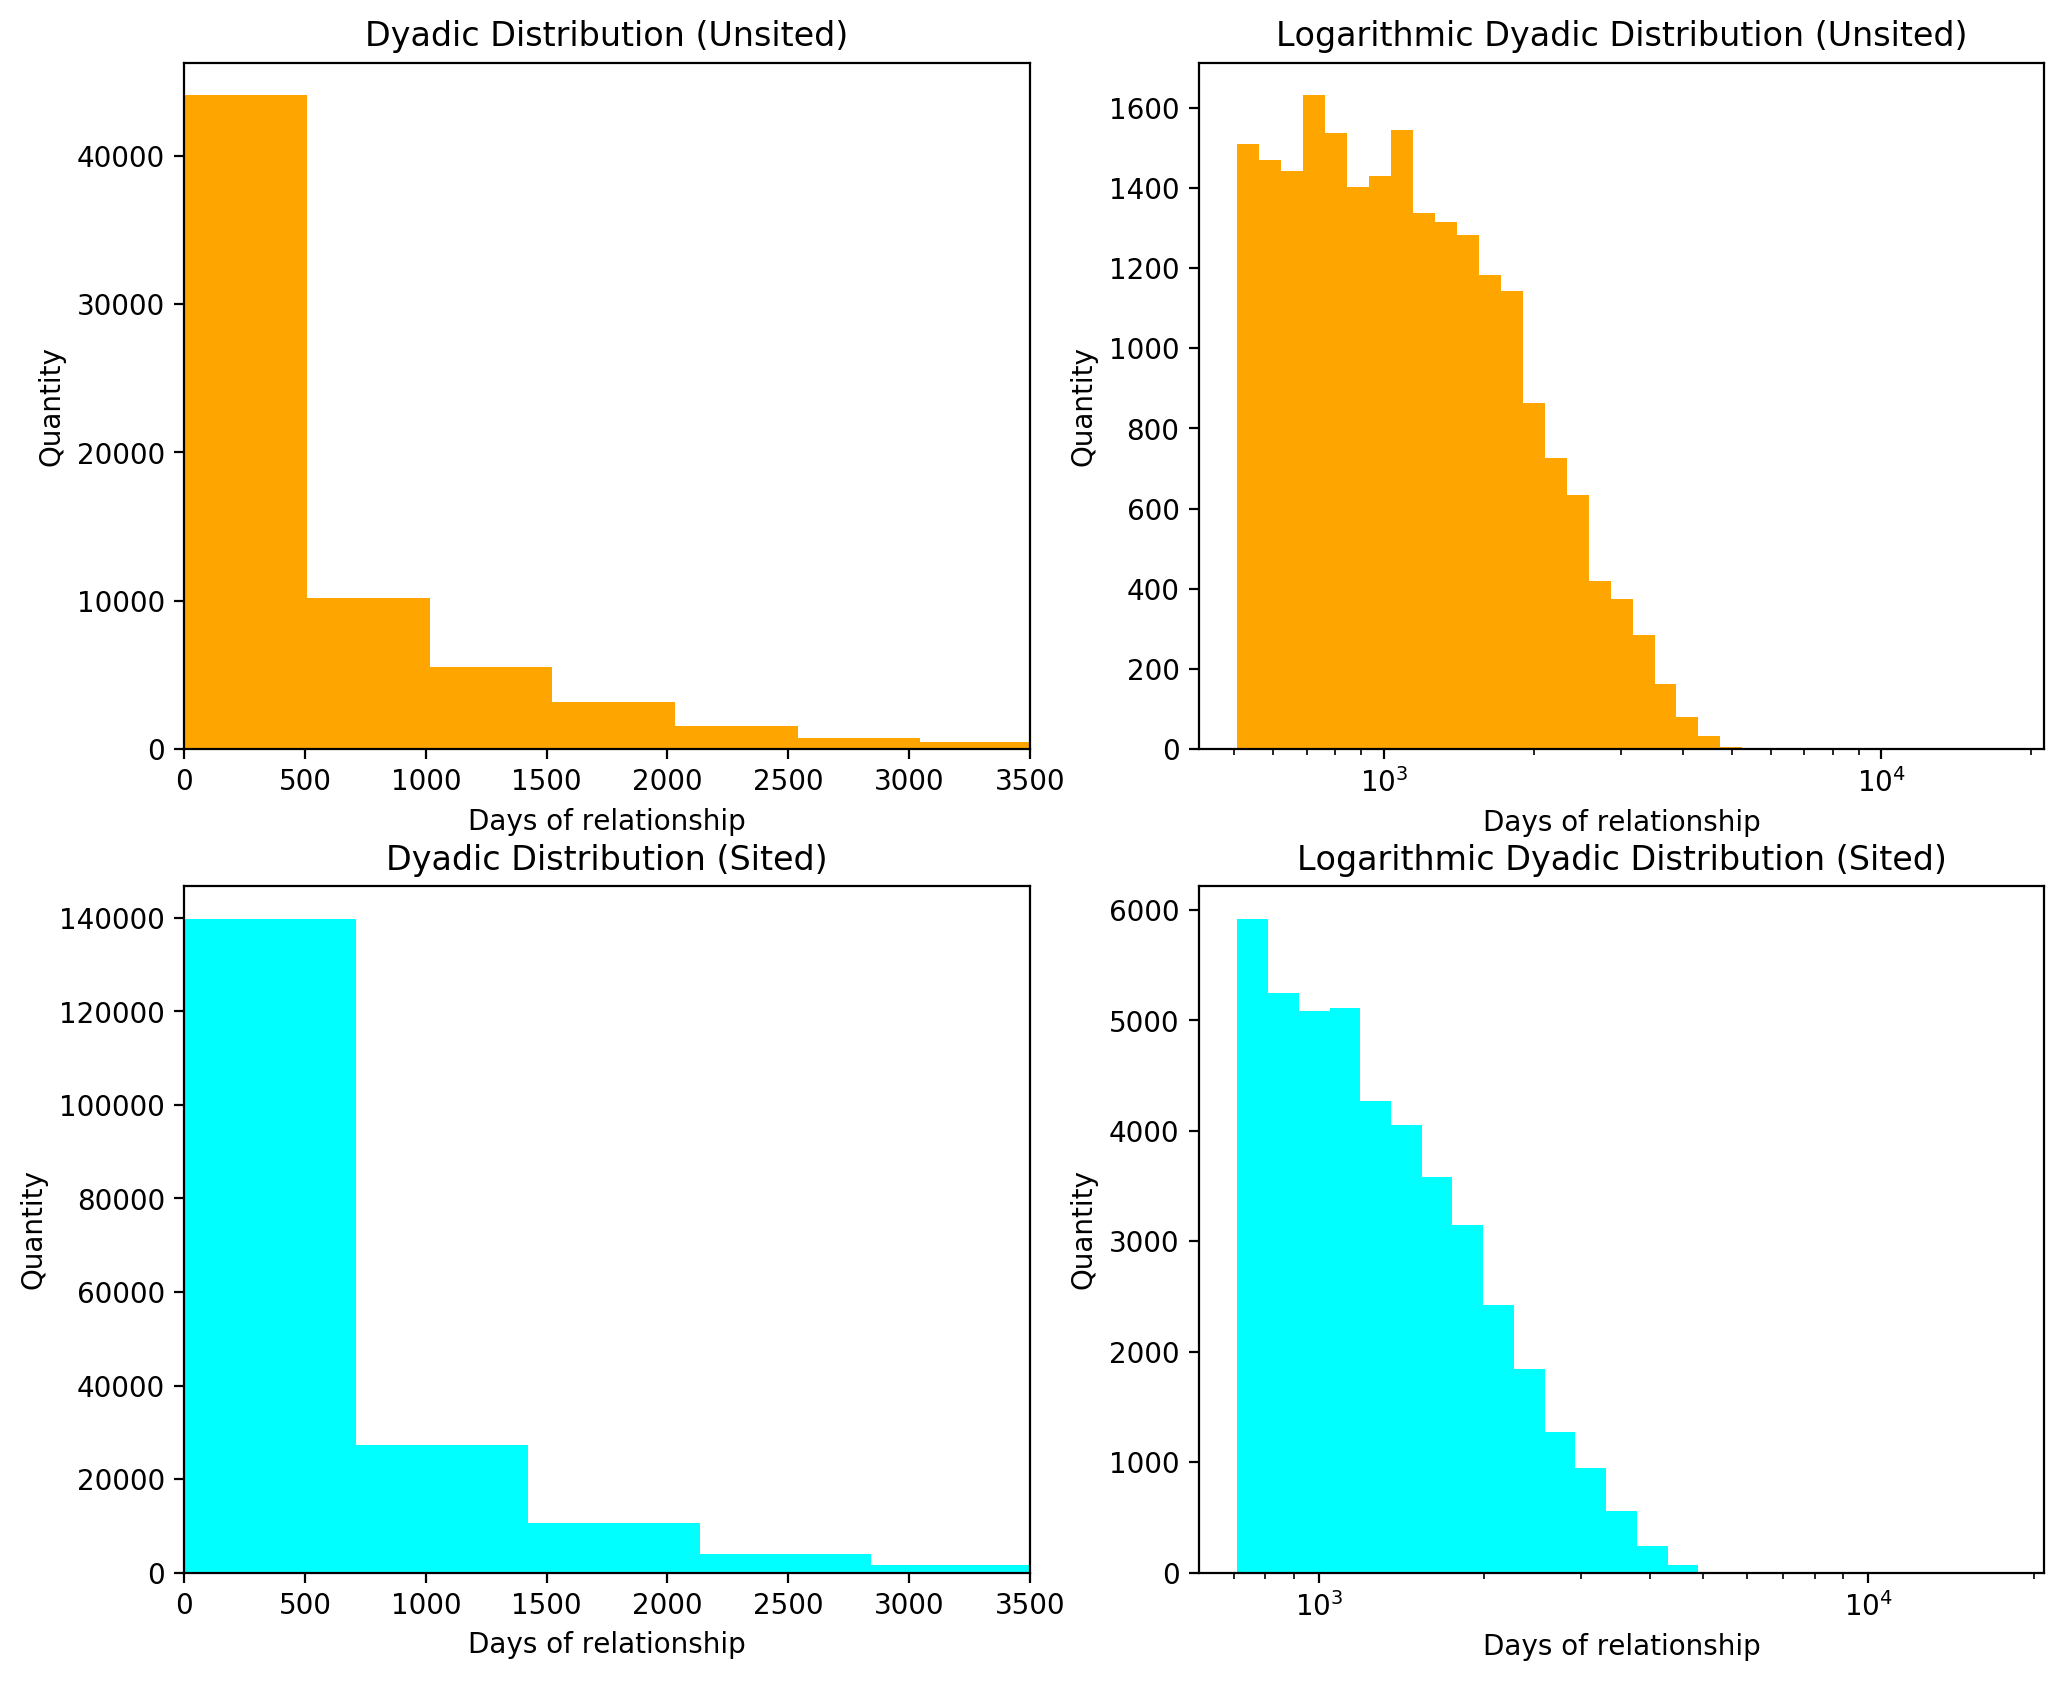

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), dpi= 200, facecolor='w', edgecolor='k')
hist, bins, _ = ax[0][0].hist(np.divide(unsited.length_d,  m_to_d), bins=35, color='orange')
logbins = np.logspace(np.log10(bins[1]),np.log10(bins[-1]),len(bins))
ax[0][1].hist(np.divide(unsited.length_d,  m_to_d), bins=logbins, color='orange')
ax[0][0].set_ylabel("Quantity")
ax[0][0].set_xlabel("Days of relationship")
ax[0][0].set_title("Dyadic Distribution (Unsited)")
ax[0][1].set_ylabel("Quantity")
ax[0][1].set_xlabel("Days of relationship")
ax[0][0].set_xlim(left = 0, right = 3500)
ax[0][1].set_title("Logarithmic Dyadic Distribution (Unsited)")
ax[0][1].set_xscale("log")

hist, bins, _ = ax[1][0].hist(np.divide(sited.length_d,  m_to_d), bins=25, color='cyan')
logbins = np.logspace(np.log10(bins[1]),np.log10(bins[-1]),len(bins))
ax[1][1].hist(np.divide(sited.length_d, m_to_d), bins=logbins, color='cyan')
ax[1][0].set_ylabel("Quantity")
ax[1][0].set_xlabel("Days of relationship")
ax[1][0].set_title("Dyadic Distribution (Sited)")
ax[1][0].set_xlim(left = 0, right = 3500)
ax[1][1].set_ylabel("Quantity")
ax[1][1].set_xlabel("Days of relationship")
ax[1][1].set_title("Logarithmic Dyadic Distribution (Sited)")
ax[1][1].set_xscale("log")

In [17]:
print("Mean of Sited: {}\t\t Mean of Unsited: {}".format(sited.length_d.mean() / m_to_d, unsited.length_d.mean() / m_to_d))

Mean of Sited: 475.0887382846423		 Mean of Unsited: 509.54635935400466


### "Cycle" Analysis

In [18]:
times = defaultdict(list)
jind_from = {from_user: to_user for from_user, to_user in zip(journals.index, journals["user_id"])}
jind_at = {from_user: to_user for from_user, to_user in zip(journals.index, journals["created_at"])}
for ind in tqdm(journals.index):
    from_uid = jind_from[ind]
    created_at = jind_at[ind]
    times[from_uid].append(created_at)

100%|██████████| 17893390/17893390 [00:17<00:00, 1022434.14it/s]


In [19]:
# if to_uid has had an update in the past 24 hours
    # add this interaction to a list to judge against ints
    # add the journal to a list to judge against journals

flagged_ints = []
flagged_jnls = []
radius = m_to_d # 1 day
for ind in tqdm(dyads.index, leave= False, position=0): #some extra args to supress tqdm errs
    from_uid = ind_from[ind]
    created_at = ind_at[ind]
    to_uid = ind_to[ind]
    int_type = ind_int[ind]
    updates = times[to_uid]
    for x in updates:
        if created_at <= x + radius and created_at > x: # bound on both sides to make sure its for this update
            flagged_ints.append((from_uid, to_uid, created_at, int_type))
            flagged_jnls.append((from_uid, x))

In [20]:
print("% of ints within 24 hrs of an update: {}%".format(100 * len(flagged_ints)/len(dyads)))

% of ints within 24 hrs of an update: 74.21258911035078%


In [21]:
print("% of journals with intx within 24 hrs: {}%".format(100 * len(flagged_jnls)/len(journals)))

% of journals with intx within 24 hrs: 13.1473074694063%


In [22]:
# huh! this is an interesting difference in proportions. 
# let's look at the distribution differences in relationship length

In [23]:
reduced = pd.read_hdf(os.path.join(h5_dir, "all_reduced.h5"))
flagged = pd.DataFrame(flagged_ints, columns = ["from", "to", "at", "int_type"])
reduced_flagged = reduced[(reduced["from"].isin(flagged["from"])) & (reduced["to"].isin(flagged["to"]))]

In [24]:
# for each dyad in dyads or recips
# collect100 * num in flagged for this dyad / num overall for this dyad

In [25]:
overall = defaultdict(int)
o_gbk = defaultdict(int)
o_com = defaultdict(int)
o_amp = defaultdict(int)
for ind in tqdm(dyads.index, leave = False, position = 0):
    from_uid = ind_from[ind]
    to_uid = ind_to[ind]
    int_type = ind_int[ind]
    overall[(from_uid, to_uid)] += 1
    if int_type == "guestbook":
        o_gbk[(from_uid, to_uid)] += 1
    elif int_type == "comment":
        o_com[(from_uid, to_uid)] += 1
    elif int_type == "amps":
        o_amp[(from_uid, to_uid)] += 1

In [26]:
flagged.int_type.unique()

array(['guestbook', 'amps', 'comment'], dtype=object)

In [27]:
flagger = defaultdict(int)
f_gbk = defaultdict(int)
f_com = defaultdict(int)
f_amp = defaultdict(int)
find_from = {from_user: to_user for from_user, to_user in zip(flagged.index, flagged["from"])}
find_to = {from_user: to_user for from_user, to_user in zip(flagged.index, flagged["to"])}
find_type = {from_user: to_user for from_user, to_user in zip(flagged.index, flagged["int_type"])}
for ind in tqdm(flagged.index, leave = False, position = 0):
    from_uid = find_from[ind]
    to_uid = find_to[ind]
    int_type = find_type[ind]
    flagger[(from_uid, to_uid)] += 1
    if int_type == "guestbook":
        f_gbk[(from_uid, to_uid)] += 1
    elif int_type == "comment":
        f_com[(from_uid, to_uid)] += 1
    elif int_type == "amps":
        f_amp[(from_uid, to_uid)] += 1

In [43]:
pcts = []; g_p = []; a_p = []; c_p = [];
for dyad in tqdm(overall.keys(), leave= False, position =0):
    try:
        if overall[dyad] > 15:
            pcts.append(flagger[dyad] / overall[dyad])
    except KeyError and ZeroDivisionError:
        continue

In [44]:
for dyad in tqdm(overall.keys(), leave= False, position =0):
    try:
        if o_gbk[dyad] > 15:
            g_p.append(f_gbk[dyad] / o_gbk[dyad])
    except KeyError and ZeroDivisionError:
        continue

In [45]:
for dyad in tqdm(overall.keys(), leave= False, position =0):
    try:
        if o_amp[dyad] > 15:
            a_p.append(f_amp[dyad] / o_amp[dyad])
    except KeyError and ZeroDivisionError:
        continue

In [46]:
for dyad in tqdm(overall.keys(), leave= False, position =0):
    try:
        if o_com[dyad] > 15:
            c_p.append(f_com[dyad] / o_com[dyad])
    except KeyError and ZeroDivisionError:
        continue

In [47]:
#- Time difference between update and amp/comment on update specifically
#- With that array ^^, for user-site pair, take the max reaction time and plot 

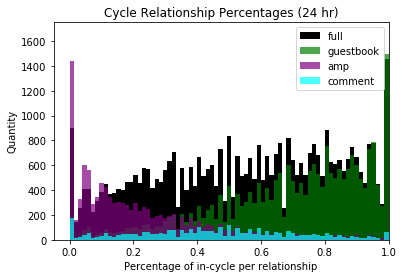

<Figure size 2400x1000 with 0 Axes>

In [48]:
%matplotlib inline 
plt.hist([x for x in pcts if x <= 1], bins=75, color='black', label="full")
plt.hist([x for x in g_p if x <= 1], bins=75, color='green', alpha=0.7, label="guestbook")
plt.hist([x for x in a_p if x <= 1], bins=75, color='purple', alpha=0.7, label="amp")
plt.hist([x for x in c_p if x <= 1], bins=75, color='cyan', alpha=0.7, label="comment")
plt.legend()

plt.xlabel("Percentage of in-cycle per relationship")
plt.ylabel("Quantity")
plt.title("Cycle Relationship Percentages (24 hr)")
plt.xlim(right=1)
plt.ylim(top=1750)

plt.figure(figsize=(12, 5), dpi=200, facecolor='w', edgecolor='k')
plt.show()

In [49]:
# for every update on a site
   # for each amp or comment made by a user
      # log (user, site, and reaction_time)
      # add reaction_time to an array for a distribution

In [50]:
aoc = sorted_df[(sorted_df.int_type != "journal") & (sorted_df.int_type != "guestbook")]

In [51]:
update_times = {from_uid : created_at for from_uid, created_at in zip(journals.journal_oid, journals.created_at)}

In [52]:
joid_at = {from_uid : created_at for from_uid, created_at in zip(aoc.index, aoc.journal_oid)}
uid_at = {from_uid : created_at for from_uid, created_at in zip(aoc.index, aoc.user_id)}
sid_at = {from_uid : created_at for from_uid, created_at in zip(aoc.index, aoc.site_id)}
ca_at = {from_uid : created_at for from_uid, created_at in zip(aoc.index, aoc.created_at)}

In [53]:
reaction_time_df = []
reaction_times = []
lost_joids = 0
for ind in tqdm(aoc.index, leave=False, position=0):
    from_uid = uid_at[ind]
    to_sid = sid_at[ind]
    created_at = ca_at[ind]
    joid = joid_at[ind]
    try:
        update_time = update_times[joid]
        reaction_times.append(created_at - update_time)
        reaction_time_df.append((from_uid, to_sid, created_at - update_time))
    except KeyError:
        lost_joids += 1

In [71]:
len([x for x in reaction_times if x >= 0]) / len(reaction_times)

0.892947411949268

In [78]:
len([x for x in reaction_times if x == 0]) / len(reaction_times)

0.76372982480007

In [79]:
len([x for x in reaction_times if x > 0])

598406

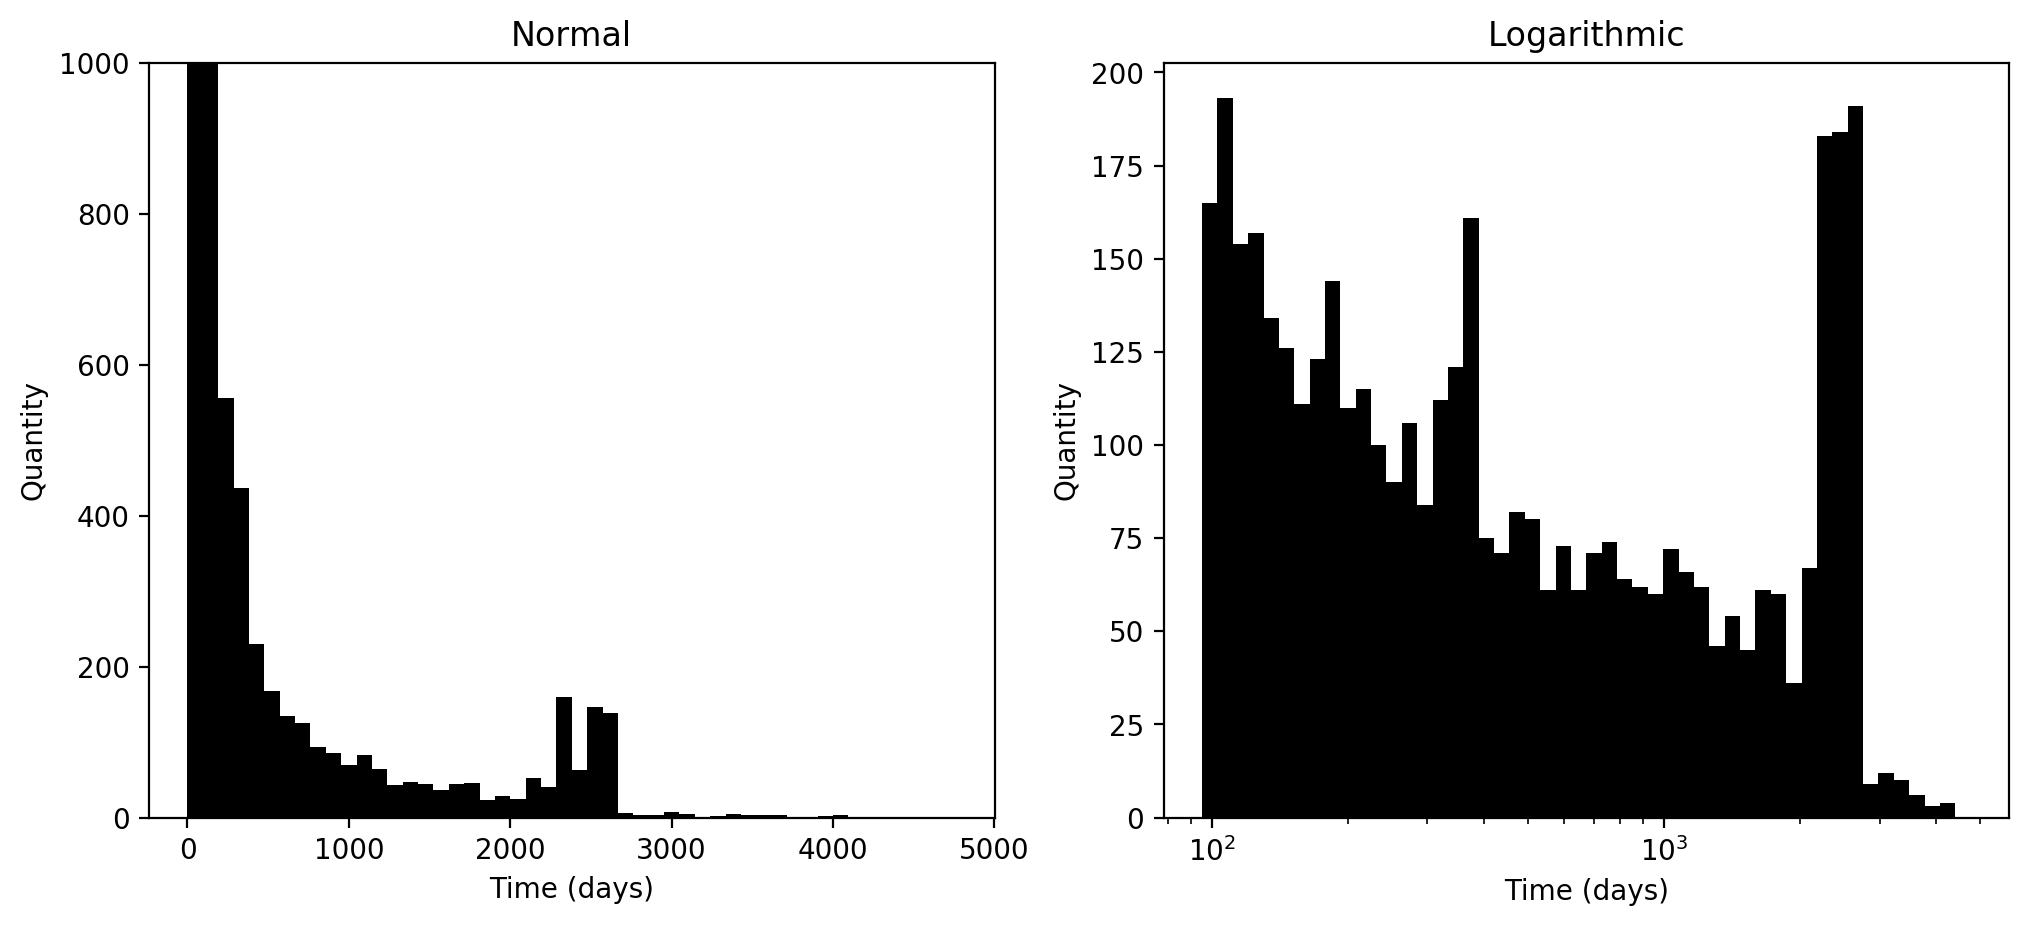

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi= 200, facecolor='w', edgecolor='k')
hist, bins, _ = ax[0].hist([x / m_to_d for x in reaction_times if x >= 0], bins=50, color='black')
logbins = np.logspace(np.log10(bins[1]),np.log10(bins[-1]),len(bins))
ax[1].hist([x / m_to_d for x in reaction_times if x >= 0], bins=logbins, color='black')
ax[0].set_ylabel("Quantity")
ax[0].set_xlabel("Time (days)")
ax[0].set_title("Normal")
ax[0].set_ylim(top=1000)
ax[1].set_ylabel("Quantity")
ax[1].set_xlabel("Time (days)")
ax[1].set_title("Logarithmic")
ax[1].set_xscale("log")

In [56]:
rdf = pd.DataFrame(reaction_time_df, columns=["from_uid", "to_sid", "reaction_time"])

In [57]:
maxes = rdf.sort_values(by=["from_uid", "to_sid", "reaction_time"]).drop_duplicates(subset=["from_uid", "to_sid"], keep='last')

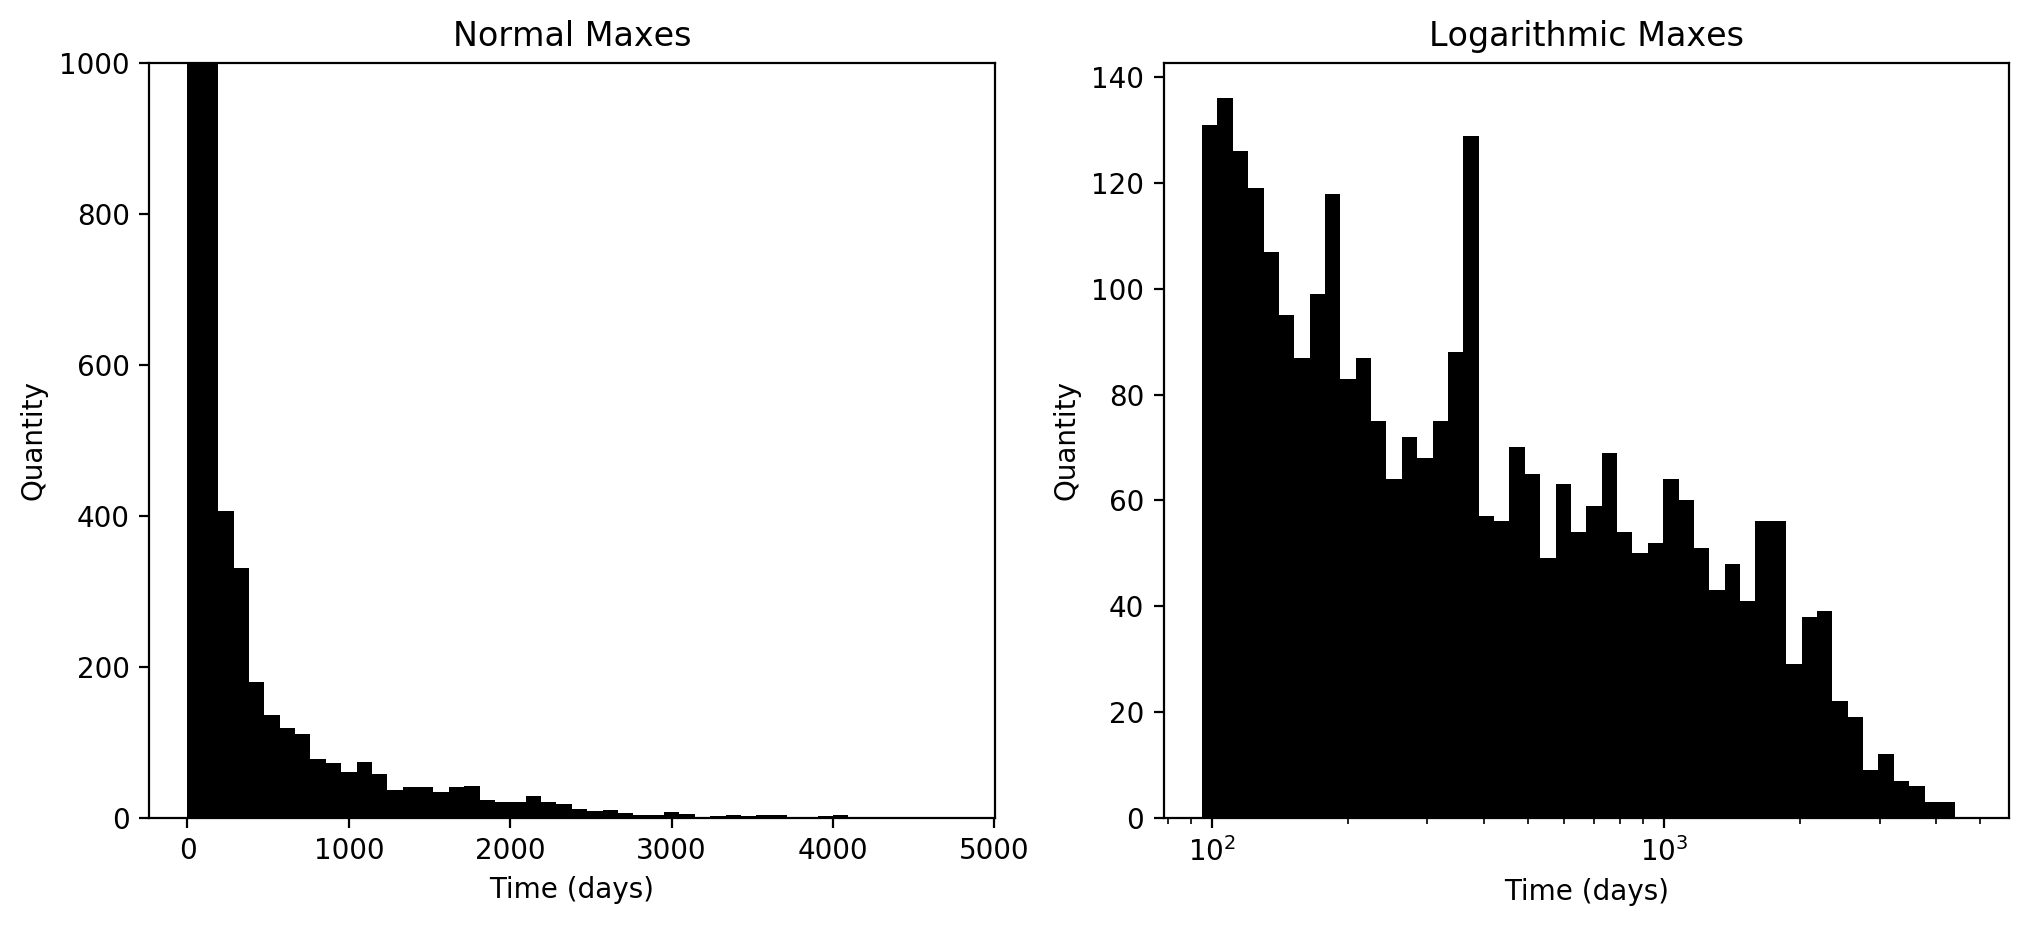

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi= 200, facecolor='w', edgecolor='k')
hist, bins, _ = ax[0].hist([x / m_to_d for x in maxes.reaction_time if x >= 0], bins=50, color='black')
logbins = np.logspace(np.log10(bins[1]),np.log10(bins[-1]),len(bins))
ax[1].hist([x / m_to_d for x in maxes.reaction_time if x >= 0], bins=logbins, color='black')
ax[0].set_ylabel("Quantity")
ax[0].set_xlabel("Time (days)")
ax[0].set_title("Normal Maxes")
ax[1].set_ylabel("Quantity")
ax[0].set_ylim(top=1000)
ax[1].set_xlabel("Time (days)")
ax[1].set_title("Logarithmic Maxes")
ax[1].set_xscale("log")

In [59]:
len(maxes) / len(rdf) # about 10% reduction; the average user makes 10 interactions

0.09593402713671684